In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import ColorMode
import random
import cv2
import os
from os import listdir

from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset", {}, "nucleus_cocoformat.json", "./stage1_train")

metadata = MetadataCatalog.get("my_dataset")
#dataset_dicts = DatasetCatalog.get("my_dataset")


WARNING [12/27 17:00:41 d2.config.compat]: Config './model/cascade_mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


'proposal_generator.anchor_generator.cell_anchors.0' has shape (30, 4) in the checkpoint but (3, 4) in the model! Skipped.
'proposal_generator.anchor_generator.cell_anchors.1' has shape (30, 4) in the checkpoint but (3, 4) in the model! Skipped.
'proposal_generator.anchor_generator.cell_anchors.2' has shape (30, 4) in the checkpoint but (3, 4) in the model! Skipped.
'proposal_generator.anchor_generator.cell_anchors.3' has shape (30, 4) in the checkpoint but (3, 4) in the model! Skipped.
'proposal_generator.anchor_generator.cell_anchors.4' has shape (30, 4) in the checkpoint but (3, 4) in the model! Skipped.
'proposal_generator.rpn_head.objectness_logits.weight' has shape (30, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) in the model! Skipped.
'proposal_generator.rpn_head.objectness_logits.bias' has shape (30,) in the checkpoint but (3,) in the model! Skipped.
'proposal_generator.rpn_head.anchor_deltas.weight' has shape (120, 256, 1, 1) in the checkpoint but (12, 256, 1, 1) in the mo

Visualization

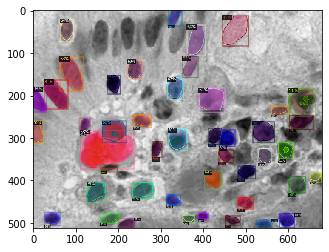

Submission

In [5]:
from skimage.measure import find_contours
from skimage.measure import label
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import dilation, erosion

# https://github.com/mirzaevinom/data_science_bowl_2018/blob/master/codes/predict.py
def postprocess_masks(ori_mask, ori_score, image, min_nuc_size=15):

    """Clean overlaps between bounding boxes, fill small holes, smooth boundaries"""
    # print(ori_mask[0].shape)
    height, width = image.shape[:2]
    
    score_threshold = 0.9

    # If there is no mask prediction or less than score threshold
    if len(ori_mask) == 0 or ori_score.all() < score_threshold:
        return

    keep_ind = np.where(np.sum(ori_mask, axis=(0, 1)) > min_nuc_size)[0]
    if len(keep_ind) < len(ori_mask):  # keep_ind possible to be zero zero
        # print(keep_ind.shape)  # would be like (0,) or like (1,)
        if(keep_ind.shape[0] != 0):
            # print(keep_ind.shape)
            ori_mask = ori_mask[:keep_ind.shape[0]]  # shape[0]:to int
            ori_scrore = ori_score[:keep_ind.shape[0]]
        else:
            ori_mask = []
            ori_score = []
        
    # can skip sort phase
    # sort_ind = np.argsort(ori_score)[::-1]
    # print(sort_ind)
    # ori_mask = ori_mask[..., sort_ind]

    overlap = np.zeros([height, width])

    masks = []
    # Removes overlaps from masks with lower score
    for i in range(len(ori_mask)):
        # Fill holes inside the mask
        mask = binary_fill_holes(ori_mask[i]).astype(np.uint8)
        # Smoothen edges using dilation and erosion
        mask = erosion(dilation(mask))
        # Delete overlaps
        overlap += mask
        mask[overlap > 1] = 0
        out_label = label(mask)
        # Remove all the pieces if there are more than one pieces
        if out_label.max() > 1:
            mask[()] = 0

        masks.append(mask)

    return masks

In [6]:
import pandas as pd
import os 

path = "./output_augment_Cascade2/"
fold = os.listdir(path)

inpath = "./stage2_test_final/"
images_name = listdir(inpath)


def last_11chars(x):
    return(x[-11:])

fold = sorted(fold, key = last_11chars)   

for weight in fold:
    cfg = get_cfg()
    cfg.merge_from_file("./model/cascade_mask_rcnn_R_50_FPN_3x.yaml")
    cfg.OUTPUT_DIR = path
    #cfg.MODEL.WEIGHTS = "./output_Cascade/model_0009999.pth"
    cfg.MODEL.WEIGHTS = os.path.join(path,weight)
    cfg.DATASETS.TRAIN = ("my_dataset",)
    cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 300000    # 300 iterations seems good enough, but you can certainly train longer
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 3 classes (data, fig, hazelnut)
    cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 32, 64, 128, 256, 512]]
    cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.2, 0.5, 1.0, 2.0, 5.0]]
    cfg.MODEL.ROI_MASK_HEAD.POOLER_RESOLUTION = 28
    cfg.TEST.DETECTIONS_PER_IMAGE = 500
    cfg.SOLVER.WARMUP_FACTOR = 0.01
    cfg.SOLVER.WARMUP_ITERS = 10000
    cfg.INPUT.CROP.SIZE = [1.0, 1.0]
    cfg.DATASETS.TEST = ("my_dataset")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
    predictor = DefaultPredictor(cfg)

    print(weight)
    
    Img_ID = []
    EncodedPixels = []
    num = 0
    conv = lambda l: ' '.join(map(str, l))
    
    for name in images_name:
        image = cv2.imread(inpath + name)
        outputs = predictor(image)
        print(num)
        num+=1
    # print(np.asarray(outputs["instances"].to('cpu')._fields['pred_masks'][0]).shape)
        masks = postprocess_masks(np.asarray(outputs["instances"].to('cpu')._fields['pred_masks']), outputs["instances"].to('cpu')._fields['scores'].numpy(), image)

        if masks: # If any objects are detected in this image
            for i in range(len(masks)): # Loop all instances
                Img_ID.append(name.replace('.png',''))            
                EncodedPixels.append(conv(rle_encoding(masks[i])))

    df = pd.DataFrame({"ImageId" : Img_ID, "EncodedPixels" : EncodedPixels})
    df.to_csv("./augment3_Cascade_csv/test_stage2_+"+weight+".csv",index=False,sep=',')

WARNING [12/27 22:26:57 d2.config.compat]: Config './model/cascade_mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
model_0004999.pth
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780


2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463


1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266


2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905


1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709


141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390


1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151


694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943


2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594


1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397


2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
WARNING [12/28 02:15:54 d2.config.compat]: Config './model/cascade_mask_rcnn_R_50_FPN_3x.y

1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840


305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554


2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282


857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
108

2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725


1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528


2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
WARNING [12/28 04:17:30 d2.config.compat]: Config './model/cascade_mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
model_0059999.pth
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
17

1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971


469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718


2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413


1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217


2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856


1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659


71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
3

1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102


632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881


2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546


1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350


2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989


1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793


246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495


2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235


798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
10

2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676


1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479


2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
WARNING [12/28 09:25:49 d2.config.compat]: Config './model/cascade_mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
model_0114999.pth
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108


1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922


408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657


2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364


960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167


2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806


1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609


model_0134999.pth
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272


1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057


576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825


2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499


1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302


2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941


1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745


187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436


1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188


740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989


2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630


1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433


2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
WARNING [12/28 14:39:29 d2.config.compat]: Config './model/cascade_mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


UnpicklingError: invalid load key, '\x18'.